In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from astropy.table import Table
import json

## Check LAE data

Let's take a look at the LAE data in the ODIN fields.  This notebook writes the data files for different samples, does some sanity-check style plots, compares to the mocks and writes a number of summary files and figures that are helpful.  It assumes that the angular clustering and mock data are computed externally.

**Note** you need to ensure that the files read by this notebook are in sync with the catalogs written by this notebook by hand.

In [3]:
# Set up paths.
import sys
#
basedir = "/pscratch/sd/m/mwhite/AnalyzeLAE/"
for subdir in ["mocks","Cobaya/lss_likelihood"]:
    sys.path.append(basedir+subdir)

In [4]:
from predict_wR           import NbodyCorrelationFunctions,ThinShellWR
from make_lae_survey_mask import SurveyMask
#from calc_wR              import calc_wt
#
# Gamma function for wp(R).
from scipy.special import gamma,erfc
from scipy.stats   import chi2  as chi2dist

## Set up the data set we'll study

In [5]:
from fiducial import chi_dict,fint_dict
print(chi_dict)
print(fint_dict)

{'N419': 3941.0, 'N501': 4448.0, 'N673': 5160.0}
{'N501': {'s0': 0.1066, 's1': 0.0307, 's2': 0.028, 's3': 0.1}}


In [6]:
filter_name = "N501"
fname       = "cosmos_"+filter_name
chi0        = chi_dict[filter_name]
zrange      = [3.075,3.175]

Take a quick look at the master file to check we're doing what we think we are.

['RELEASE', 'BRICKID', 'BRICKNAME', 'OBJID', 'BRICK_PRIMARY', 'MASKBITS', 'FITBITS', 'TYPE', 'RA', 'DEC', 'RA_IVAR', 'DEC_IVAR', 'BX', 'BY', 'DCHISQ', 'EBV', 'MJD_MIN', 'MJD_MAX', 'REF_CAT', 'REF_ID', 'PMRA', 'PMDEC', 'PARALLAX', 'PMRA_IVAR', 'PMDEC_IVAR', 'PARALLAX_IVAR', 'REF_EPOCH', 'GAIA_PHOT_G_MEAN_MAG', 'GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR', 'GAIA_PHOT_G_N_OBS', 'GAIA_PHOT_BP_MEAN_MAG', 'GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR', 'GAIA_PHOT_BP_N_OBS', 'GAIA_PHOT_RP_MEAN_MAG', 'GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR', 'GAIA_PHOT_RP_N_OBS', 'GAIA_PHOT_VARIABLE_FLAG', 'GAIA_ASTROMETRIC_EXCESS_NOISE', 'GAIA_ASTROMETRIC_EXCESS_NOISE_SIG', 'GAIA_ASTROMETRIC_N_OBS_AL', 'GAIA_ASTROMETRIC_N_GOOD_OBS_AL', 'GAIA_ASTROMETRIC_WEIGHT_AL', 'GAIA_DUPLICATED_SOURCE', 'GAIA_A_G_VAL', 'GAIA_E_BP_MIN_RP_VAL', 'GAIA_PHOT_BP_RP_EXCESS_FACTOR', 'GAIA_ASTROMETRIC_SIGMA5D_MAX', 'GAIA_ASTROMETRIC_PARAMS_SOLVED', 'FLUX_N501', 'FLUX_N673', 'FLUX_IVAR_N501', 'FLUX_IVAR_N673', 'FIBERFLUX_N501', 'FIBERFLUX_N673', 'FIBERTOTFL

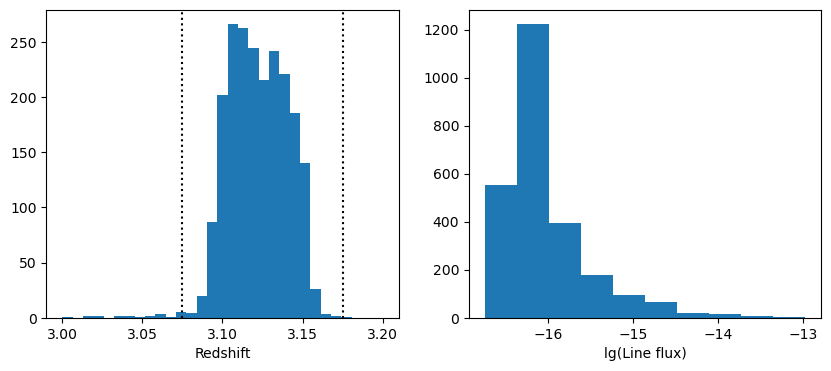

In [7]:
dat = Table.read('odin_lae_cosmos_'+filter_name+'.fits')
print(dat.keys())
print("\n")
print("Total entries in catalog: ",len(dat))
#
dat = dat[ dat['VI_QUALITY_FINAL']>=2.0 ]
print("Number with VI_Quality >= 2.0: ",len(dat))
#
fig,ax = plt.subplots(1,2,figsize=(10,4))
# Histogram the redshifts.
bins = np.linspace(3.0,3.2,32)
ax[0].hist(dat['VI_Z_FINAL'],bins=bins)
for zvalue in zrange:
    ax[0].axvline(zvalue,ls=':',color='k')
ax[0].set_xlabel(r'Redshift')
# Historgram the line fluxes.
ax[1].hist(np.log10(dat['LINEFLUX']))
ax[1].set_xlabel(r'lg(Line flux)')
#
print("Median line flux (lg): ",np.log10(np.median(dat['LINEFLUX'])))

## Read/make catalogs

Read in the catalogs, masks, etc., and write out the data that we're actually going to use.

In [8]:
# Load the survey mask.
weight_file = '/global/cfs/cdirs/desi/users/raichoor/laelbg/odin/phot/'
weight_file+= 'odin-cosmos-fracflux_n501-hpmap-nside2048.fits'
mask = SurveyMask("lae_{:s}_msk.fits".format(fname),weight_file)
print("In-survey area ",mask.area()," deg2.")

In-survey area  9.343340199646017  deg2.


In [9]:
# Read the targets from file.
dat = Table.read('odin_lae_cosmos_'+filter_name+'.fits')
print("Read information for ",len(dat)," data objects from file.")
#
ran = Table.read("lae_"+fname+"_ran.fits")
print("Read information for ",len(ran)," rand objects from file.")

Read information for  7353  data objects from file.
Read information for  852080  rand objects from file.


In [10]:
# Write data catalogs for each of our selections:
for selection in [0,1,2,3,4]:
    if selection<0:
        dat = Table.read('LAE_Candidates_NB501_v1_targeting.fits')
        dat = dat[ dat['PRIORITY']==1 ]
    else:
        dat = Table.read('odin_lae_cosmos_'+filter_name+'.fits')
        # Select objects -- no longer need the priority flag.
        if selection<=3:
            selectstr = 'Selection'+str(selection)
        else:
            selectstr = 'Selection3'
        dat = dat[ dat[selectstr]==1 ]
        if selection>3:
            dat = dat[ dat['LINEFLUX']>7.5e-17 ]
    dat = dat[ dat['MASKBITS']==0 ]
    dat = dat[ mask(dat['RA'],dat['DEC']) ]
    #
    dat['WT'] = 1.0/( mask.weights(dat['RA'],dat['DEC']) )
    lgfmed = np.log10(np.median(dat['LINEFLUX']))
    #
    dat.write('odin_s{:d}_'.format(selection)+fname+'_dat.fits',overwrite=True)
    #
    allvid  = dat[ (dat['VI_QUALITY_FINAL']>  -1) ]
    allgood = dat[ (dat['VI_QUALITY_FINAL']>=2.0) ]
    inrange = dat[ (dat['VI_QUALITY_FINAL']>=2.0)&\
                   (dat['VI_Z_FINAL']>zrange[0])&\
                   (dat['VI_Z_FINAL']<zrange[1]) ]
    inrange = float(len(inrange))
    #
    print("Selection "+str(selection)+':')
    print("  Keeping ",len(dat)," data objects after cuts and mask.")
    print("  or {:.1f} per deg2.".format(dat['WT'].sum()/mask.area()))
    print("  Median line flux (lg): ",lgfmed)
    print("  Interloper fraction {:.4f}-{:.4f}".\
          format(1-inrange/len(allgood),1-inrange/len(allvid)))

Selection 0:
  Keeping  2271  data objects after cuts and mask.
  or 272.2 per deg2.
  Median line flux (lg):  -16.110490626028636
  Interloper fraction 0.1072-0.1876
Selection 1:
  Keeping  1665  data objects after cuts and mask.
  or 199.6 per deg2.
  Median line flux (lg):  -16.149761027029612
  Interloper fraction 0.0310-0.0975
Selection 2:
  Keeping  1487  data objects after cuts and mask.
  or 178.3 per deg2.
  Median line flux (lg):  -16.13372022502766
  Interloper fraction 0.0287-0.0847
Selection 3:
  Keeping  1956  data objects after cuts and mask.
  or 234.4 per deg2.
  Median line flux (lg):  -16.137034231732954
  Interloper fraction 0.0388-0.1282
Selection 4:
  Keeping  931  data objects after cuts and mask.
  or 111.8 per deg2.
  Median line flux (lg):  -15.980472391775706
  Interloper fraction 0.0499-0.1350


In [11]:
# Now pick a selection to focus on.
selection = 3
dat = Table.read('odin_s{:d}_'.format(selection)+fname+'_dat.fits')

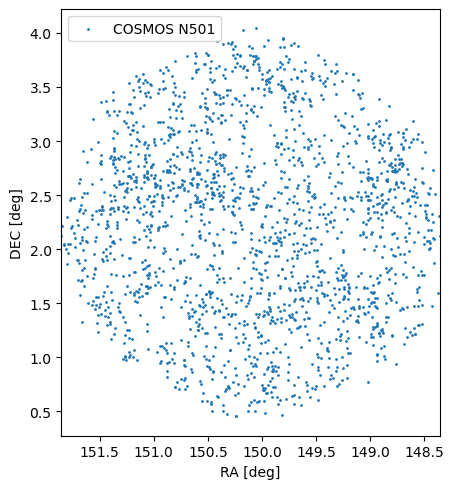

In [12]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
#
ax.scatter(dat['RA'],dat['DEC'],s=1,label='COSMOS N501')
#
ax.legend()
#
ax.set_xlim(np.max(dat['RA']),np.min(dat['RA']))
ax.set_aspect('equal')
ax.set_xlabel(r'RA [deg]')
ax.set_ylabel(r'DEC [deg]')
#
plt.tight_layout()
plt.savefig('odin_s{:d}_'.format(selection)+fname+'_field.png')

**At this point you should run the compute_clustering code to make sure we have w(R).**

In [13]:
# Read the clustering of the data -- computed with "compute_clustering.py"
# assuming the data files above have been created.
# (This avoids needing to deal with GSL from within
# the notebook).
rval,wx = np.loadtxt('odin_s{:d}_'.format(selection)+fname+'_wx.txt',unpack=True)
Ndof    = rval.size
#
print("R=",rval)
print("wR=",wx)
#
print("Ndof=",Ndof)
for clev in [0.68,0.90,0.95]:
    clim = chi2dist.ppf(clev,Ndof)
    print("P(chi2<{:6.2f})={:6.2f}".format(clim,clev))

R= [ 0.56642  0.8376   1.23861  1.83161  2.70851  4.00522  5.92276  8.75832
 12.95144 19.15203]
wR= [0.42729 0.50316 0.52221 0.39225 0.30806 0.23419 0.15782 0.10195 0.10151
 0.06575]
Ndof= 10
P(chi2< 11.50)=  0.68
P(chi2< 15.99)=  0.90
P(chi2< 18.31)=  0.95


## Now work out the "theory" to compare against

The HOD models have been pre-computed in "mocks".  There are several boxes, and you want to use the largest box for which you have reasonable convergence to best capture the large-r behavior.

In [14]:
def compute_r0_from_wR(R,wp,rfid=5.0,gam=1.8):
    """Calculates r0 from wp(Rfid)."""
    wfid = 10.**np.interp(np.log10(rfid),np.log10(R),np.log10(wp))
    fact = rfid**(1-gam) * np.sqrt(np.pi)*gamma(gam/2-0.5)/gamma(gam/2)
    r0   = (wfid / fact)**(1./gam)
    return(r0)

In [15]:
# Theory.
#ximod = NbodyCorrelationFunctions("../mocks/lae_n501_c000_ph100_s.json")
#ximod = NbodyCorrelationFunctions("../mocks/lae_n501_c000_ph300_s.json")
ximod = NbodyCorrelationFunctions("../mocks/lae_n501_c000_ph310_s.json")
thy   = ThinShellWR(ximod,4448.,"lae_cosmos_N501_sfn.txt")
Nmock = len(ximod.mod['mocks'])
ihod  = 78

In [16]:
# Compare our projected clustering to the power-law
# fits from Khostovan+19.
mock= ximod.mod['mocks'][ihod]
R   = np.array(ximod.mod['R'])
wp  = np.array(mock['wp'])
print(R)
print(wp)
#
# Table 2 of Khostovan+19: https://arxiv.org/pdf/1811.00556.pdf
# IA427: z=2.51 \pm 0.08
# gam,r0,dr0 = 1.80,4.13,0.42 # Mpc/h.
# IA484: z=2.99 \pm 0.09
# gam,r0,dr0 = 1.80,3.85,0.45 # Mpc/h.
# IA505: z=3.17 \pm 0.09
gam,r0,dr0 = 1.80,3.62,0.52 # Mpc/h.
# IA679: z=4.58 \pm 0.14
# gam,r0,dr0 = 1.80,10.81,1.75 # Mpc/h.
# Compute wp(R) as:
wpR = R**(1-gam) * r0**gam * np.sqrt(np.pi)*gamma(gam/2-0.5)/gamma(gam/2)
print(wpR)
print(wp/wpR)

[ 0.44926232  0.57213695  0.72861817  0.92789749  1.18168031  1.50487352
  1.91646106  2.44061907  3.1081359   3.95822065  5.04080619  6.41948222
  8.17523038 10.41118108 13.25867118 16.88495859 21.50304679 27.38419634
 34.87385841 44.41196614]
[29.51137975 26.23209652 23.33050275 20.6237885  18.30935564 16.14025081
 14.14231616 12.3788691  10.69786749  9.12763391  7.68855928  6.3795817
  5.16119818  4.07824381  3.10791018  2.27059799  1.58520414  1.03731268
  0.66467757  0.42372452]
[70.69949452 58.26614815 48.0193535  39.57457948 32.61491934 26.87919814
 22.15217169 18.25644902 15.04583548 12.39984649 10.21918612  8.42202078
  6.94090833  5.72026711  4.71429015  3.8852262   3.201963    2.63885975
  2.1747849   1.79232313]
[0.41741995 0.45021161 0.48585624 0.52113727 0.56137976 0.60047367
 0.63841669 0.67805459 0.71101851 0.73610862 0.75236513 0.75748824
 0.74359117 0.71294639 0.65925305 0.58441848 0.4950726  0.39309125
 0.30562911 0.23641079]


In [17]:
# Compute the theory prediction for this mock.
Rs    = np.geomspace(0.5,21,25)
wofR  = thy(Rs,ihod)

In [18]:
# Can use the mocks to compute errorbars.
dd   = np.loadtxt("../mocks/mc_cosmos_N501_wR.txt")
corr = np.zeros( (dd.shape[0],dd.shape[0]) )
fin  = open("../mocks/mc_cosmos_N501_wR.txt","r")
inp  = "# Dummy"
while not inp.startswith("# Correlation matrix"):
    if inp.startswith("# Sampling by"):
        fsamp = float( inp[inp.find("g by")+4:inp.find("to get")] )
    inp = fin.readline()
for i in range(dd.shape[0]):
    inp = fin.readline()[1:]
    xx  = [float(x) for x in inp.split()]
    for j in range(dd.shape[0]):
        corr[i,j] = xx[j]
cov = np.zeros_like(corr)
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        cov[i,j]=dd[i,2]*corr[i,j]*dd[j,2]
err = np.sqrt(np.diag(cov))
cinv= np.linalg.inv(cov)
print("Sampling fraction ",fsamp)

Sampling fraction  0.025


## Write a summary file

In [19]:
outd = {}
outd['fname'   ] = fname
outd['selection']= selection
outd['N_LAE'   ] = len(dat['RA'])
outd['N_RAN'   ] = len(ran['RA'])
outd['area'    ] = mask.area()
outd['chi0'    ] = chi0
outd['f_int'   ] = fint_dict[filter_name]['s'+str(selection)]
outd['f_samp'  ] = fsamp
outd['R'       ] = rval.tolist()
outd['wR'      ] = wx.tolist()
outd['werr'    ] = err.tolist()
outd['cov'     ] = cov.tolist()
with open('odin_s{:d}_'.format(selection)+fname+'_wR.json','w') as fout:
    json.dump(outd,fout)

## Write a model file

In [20]:
mock = ximod.mod['mocks'][ihod]
#
outd = {}
outd['fname'   ] = fname
outd['selection']= selection
outd['ihod'    ] = ihod
outd['r0'      ] = compute_r0_from_wR(ximod.mod['R'],mock['wp'])
outd['Rs'      ] = Rs.tolist()
outd['wR'      ] = wofR.tolist()
outd['ss'      ] = ximod.mod['R']
outd['kk'      ] = ximod.mod['k']
for k in ['hod','wp','xi0','xi2','pk0','pk2']:
    outd[k] = mock[k]
#
with open('odin_s{:d}_'.format(selection)+fname+'_mod.json','w') as fout:
    json.dump(outd,fout)

## Compare theory and observation 

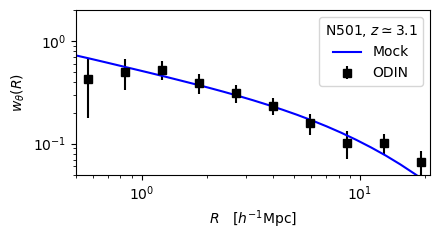

In [21]:
fig,ax = plt.subplots(1,1,figsize=(4.5,2.5))
#
ax.errorbar(rval,wx,yerr=err,fmt='s',color='k',label=r'ODIN')
ax.plot(Rs,wofR,'b-',label=r'Mock')
#
ax.legend(title='N501, $z\simeq 3.1$')
#
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.50,21)
ax.set_ylim(0.05, 2)
ax.set_xlabel(r'$R\quad [h^{-1}{\rm Mpc}]$')
ax.set_ylabel(r'$w_\theta(R)$')
#
plt.tight_layout()
plt.savefig('odin_s{:d}_'.format(selection)+fname+'_wR.png')
plt.savefig('odin_s{:d}_'.format(selection)+fname+'_wR.pdf')

In [22]:
# Now we can compute chi^2 for each HOD model
# a print those that are "reasonable fits".
clst,rlst = [],[]
print("# {:1s} {:>6s} {:>6s}  {:s}".format(" ","chi2","r0","HOD params"))
for ihod in range(Nmock):
    wofR = thy(rval,ihod)
    chi2 = np.dot(wofR-wx,np.dot(cinv,wofR-wx))
    mm   = ximod.mod['mocks'][ihod]
    r0   = compute_r0_from_wR(ximod.mod['R'],mm['wp'])
    #
    clst.append(chi2)
    rlst.append(r0)
    #
    if chi2<chi2dist.ppf(0.90,Ndof):
        outstr = "{:3d} {:6.2f} {:6.2f}".format(ihod,chi2,r0)
        for x in mm['hod']:
            outstr += " {:6.2f}".format(x)
        print(outstr)
#
clst   = np.array(clst)
rlst   = np.array(rlst)
minhod = np.argmin(clst)
print("\nBest-fitting HOD is ",minhod)

#     chi2     r0  HOD params
  0   9.19   2.67  10.60  11.30   0.50   1.00   0.33
  1   9.21   2.66  10.60  11.60   0.50   1.00   0.33
  2   9.20   2.67  10.60  11.90   0.50   1.00   0.33
  3  11.61   2.51  10.60  11.30   0.66   1.00   0.33
  4  11.60   2.51  10.60  11.60   0.66   1.00   0.33
  5  11.58   2.51  10.60  11.90   0.66   1.00   0.33
  6   9.15   2.66  10.60  11.30   0.50   1.00   0.50
  7   9.13   2.68  10.60  11.60   0.50   1.00   0.50
  8   9.21   2.67  10.60  11.90   0.50   1.00   0.50
  9  11.57   2.51  10.60  11.30   0.66   1.00   0.50
 10  11.57   2.52  10.60  11.60   0.66   1.00   0.50
 11  11.57   2.51  10.60  11.90   0.66   1.00   0.50
 12   9.23   2.67  10.60  11.30   0.50   1.00   0.66
 13   9.15   2.68  10.60  11.60   0.50   1.00   0.66
 14   9.12   2.68  10.60  11.90   0.50   1.00   0.66
 15  11.54   2.52  10.60  11.30   0.66   1.00   0.66
 16  11.58   2.50  10.60  11.60   0.66   1.00   0.66
 17  11.63   2.51  10.60  11.90   0.66   1.00   0.66
 18   8.11   2.7

In [23]:
# Work out the mean and std.dev. for r0.
prob  = np.exp(-0.5*(clst-Ndof))
prob /= np.sum(prob)
r0avg = np.sum(rlst*prob)
r0err = np.sqrt( np.sum(rlst**2*prob)-r0avg**2 )
print("r0={:.2f} +/- {:.2f}".format(r0avg,r0err))
# Now do best fit and Delta-chi2=1.
r0avg = rlst[minhod]
r0err = np.max(rlst[(clst<clst[minhod]+1)&(rlst>r0avg)])-r0avg
print("r0={:.2f} +/- {:.2f}".format(r0avg,r0err))

r0=3.01 +/- 0.21
r0=3.09 +/- 0.17


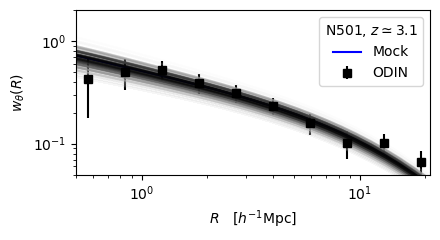

In [24]:
# Look at the models, color-coded by goodness-of-fit.
fig,ax = plt.subplots(1,1,figsize=(4.5,2.5))
#
ax.errorbar(rval,wx,yerr=err,fmt='s',color='k',label=r'ODIN')
#
for ihod in range(Nmock):
    wofR = thy(Rs,ihod)
    alpha= np.exp(-0.5*(clst[ihod]-clst[minhod]))
    if ihod==minhod:
        ax.plot(Rs,wofR,'b-',label=r'Mock')
    else:
        ax.plot(Rs,wofR,'-',color=str(1-alpha),alpha=0.3*alpha)
#
ax.legend(title='N501, $z\simeq 3.1$')
#
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.50,21)
ax.set_ylim(0.05, 2)
ax.set_xlabel(r'$R\quad [h^{-1}{\rm Mpc}]$')
ax.set_ylabel(r'$w_\theta(R)$')
#
plt.tight_layout()
##plt.savefig('odin_p{:d}_'.format(selection)+fname+'_wR.png')
##plt.savefig('odin_p{:d}_'.format(selection)+fname+'_wR.pdf')

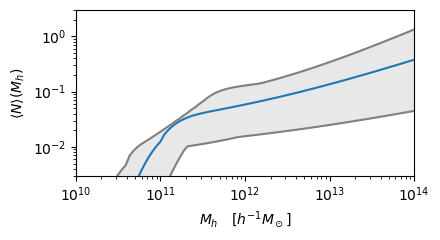

In [25]:
# Plot the HODs, shaded by goodness-of-fit.
fig,ax = plt.subplots(1,1,figsize=(4.5,2.5))
#
nobj_best = ximod.mod['mocks'][minhod]['nobj']
mhalo = np.logspace(10.0,14.5,100)
hodmin= 0*mhalo + 1e30
hodmax= 0*mhalo - 1.0
for ihod in range(Nmock):
    alpha = np.exp(-0.5*(clst[ihod]-clst[minhod]))
    samp  = ximod.mod['mocks'][ihod]       
    mcut  = 10.**samp['hod'][0]
    m1    = 10.**samp['hod'][1]
    sigm  = samp['hod'][2]
    kapp  = samp['hod'][3]
    alph  = samp['hod'][4]
    frac  = fsamp * nobj_best/samp['nobj']
    ncen  = 0.5*erfc(np.log(mcut/mhalo)/np.sqrt(2.0)/sigm)
    nsat  = (mhalo-kapp*mcut).clip(0,1e30)
    nsat  = ( (nsat/m1)**alph ) * ncen
    if clst[ihod]<chi2dist.ppf(0.95,Ndof):
        hodmin= np.minimum(hodmin,frac*(ncen+nsat))
        hodmax= np.maximum(hodmax,frac*(ncen+nsat))
    if ihod==minhod:
        ax.plot(mhalo,frac*(ncen+nsat),color='C0')
    #ax.plot(mhalo,frac*(ncen+nsat),'-',color=str(1-alpha),alpha=0.3*alpha)
#
ax.plot(mhalo,hodmin,'-',color='grey')
ax.plot(mhalo,hodmax,'-',color='grey')
ax.fill_between(mhalo,hodmin,hodmax,color='lightgrey',alpha=0.5)
#
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e10,1e14)
ax.set_ylim(3e-3,3.00)
ax.set_xlabel(r'$M_h\quad [h^{-1}M_\odot]$')
ax.set_ylabel(r'$\langle N\rangle(M_h)$')
#
plt.tight_layout()
plt.savefig('odin_s{:d}_'.format(selection)+fname+'_hod.png')
plt.savefig('odin_s{:d}_'.format(selection)+fname+'_hod.pdf')

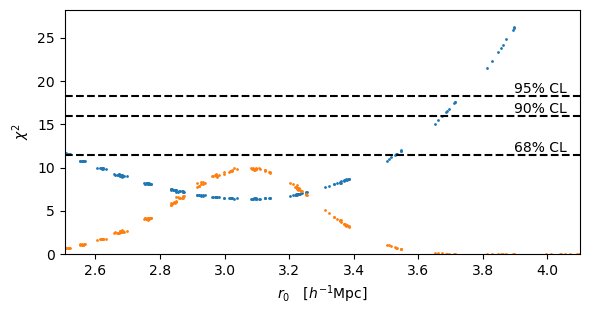

In [26]:
# Look at how chi^2 and r0 are correlated.
fig,ax = plt.subplots(1,1,figsize=(6,3.25))
#
ax.scatter(rlst,clst,s=1)
ax.scatter(rlst,Ndof*prob/prob.max(),s=1)
#
for clev in [0.68,0.90,0.95]:
    clim = chi2dist.ppf(clev,Ndof)
    ax.axhline(clim,ls='--',color='k')
    ax.text(0.99*np.max(rlst),clim,'{:.0f}% CL'.format(100*clev),\
            ha='right',va='bottom')
#
ax.set_xlim(np.min(rlst),np.max(rlst))
ax.set_ylim(0.0,chi2dist.ppf(0.99,Ndof)+5)
#
ax.set_xlabel(r'$r_0\quad [h^{-1}{\rm Mpc}]$')
ax.set_ylabel(r'$\chi^2$')
#
plt.tight_layout()
plt.savefig('odin_s{:d}_'.format(selection)+fname+'_chi2.png')

# The End